#### 5 year Forecasting With ResellerSales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '0' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60914,2014-05-01,Reseller,316.860,Southwest
60915,2014-05-01,Reseller,809.760,Southwest
60916,2014-05-01,Reseller,3274.800,Southwest
60917,2014-05-01,Reseller,97.182,Southwest


In [4]:
df.OrderDate.max() 

Timestamp('2014-05-01 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [7]:
online_channel= df.loc[df['Region'] == 'Southeast',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60873,2014-05-01,Reseller,2753.988,Southeast
60874,2014-05-01,Reseller,125.982,Southeast
60875,2014-05-01,Reseller,251.964,Southeast
60876,2014-05-01,Reseller,125.982,Southeast


### Data Preprocessing

In [8]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [9]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,139164.1943
1,2011-07-01,302889.7185
2,2011-08-01,138208.9534
3,2011-08-31,170547.2734
4,2011-10-01,447998.4794
5,2011-10-31,252006.3845
6,2011-12-01,191468.4959
7,2012-01-01,311908.3705
8,2012-01-29,167508.1474
9,2012-02-29,246363.2444


### Indexing with Time Series Data

In [10]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-07-01', '2011-08-01', '2011-08-31',
               '2011-10-01', '2011-10-31', '2011-12-01', '2012-01-01',
               '2012-01-29', '2012-02-29', '2012-03-30', '2012-04-30',
               '2012-05-30', '2012-06-30', '2012-07-31', '2012-08-30',
               '2012-09-30', '2012-10-30', '2012-11-30', '2012-12-31',
               '2013-01-28', '2013-02-28', '2013-03-30', '2013-04-30',
               '2013-05-30', '2013-06-30', '2013-07-31', '2013-08-30',
               '2013-09-30', '2013-10-30', '2013-11-30', '2013-12-31',
               '2014-01-29', '2014-03-01', '2014-03-31', '2014-05-01'],
              dtype='datetime64[ns]', name='OrderDate', freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [12]:
y['2014':]

OrderDate
2014-01-01    196532.1160
2014-02-01    202156.9071
2014-03-01    202156.9071
2014-04-01    269678.6156
2014-05-01    269678.6156
Freq: MS, Name: Total_Sales, dtype: float64

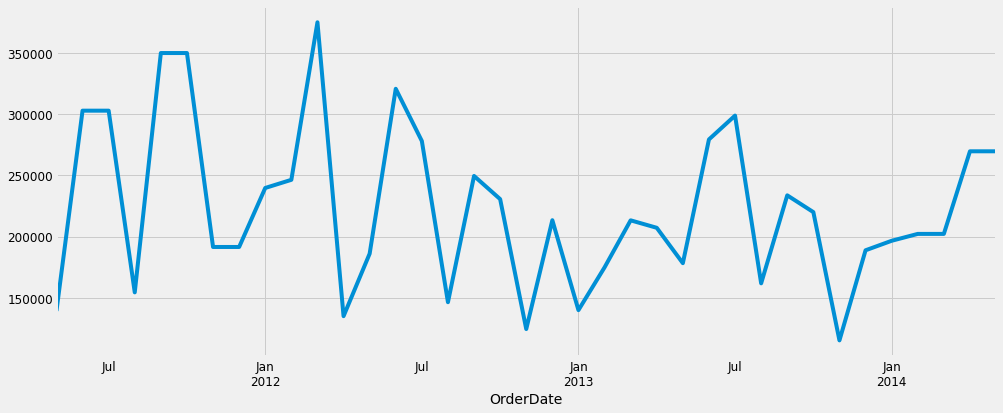

In [13]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [15]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:994.7752175962673
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:839266.610245412
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:603.2477852926274
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:295.6504492153119
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:622.6757776775651
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:596.0802703232682
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:315.79681223454514
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:297.64914200071667
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:945.9452222290112
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:619534.2110449234
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:577.2671117708363
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:273.2139196810193
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:670.9707128216021
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:619.4019510567451
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:322.5335114418748
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:275.21395871486806
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:901.5129503116272
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:581.0974146919376
ARIMA(0,

 ### Fitting an ARIMA Time Series Model

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1268      1.684      0.075      0.940      -3.174       3.428
ma.L1         -0.9612      0.110     -8.775      0.000      -1.176      -0.746
ar.S.L12      -0.2327      9.253     -0.025      0.980     -18.368      17.903
ma.S.L12       0.4135      8.530      0.048      0.961     -16.306      17.133
sigma2      3.541e+09    8.1e-10   4.37e+18      0.000    3.54e+09    3.54e+09


### Validating forecasts

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-05-31 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()



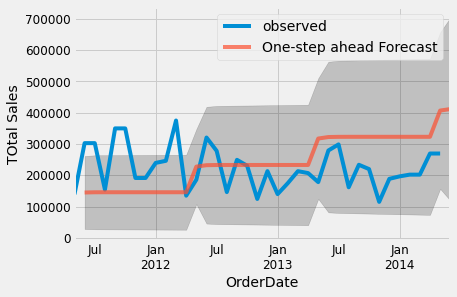

In [18]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [19]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 13392162624.81


In [20]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 115724.51


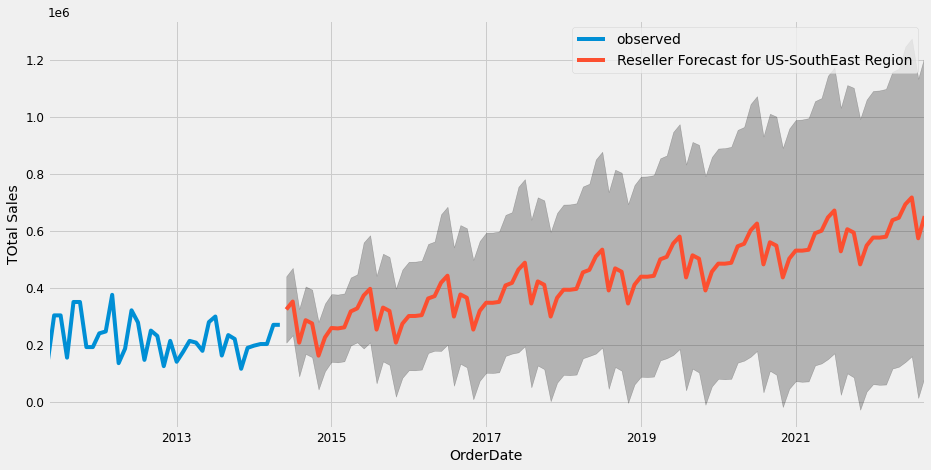

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Reseller Forecast for US-SouthEast Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()
plt.show()